In [6]:
import xtrack as xt
import numpy as np
import bpmeth
import matplotlib.pyplot as plt
from cpymad.madx import Madx
import sympy as sp
import pandas as pd
from save_read_twiss import save_twiss

In [7]:
##########################
# ELENA lattice in MAD-X #
##########################

madx = Madx()
madx.call("acc-models-elena/elena.seq")
madx.call("acc-models-elena/elena.dbx")
madx.call("acc-models-elena/tools/splitEle_installBPM.madx")
madx.call("acc-models-elena/scenarios/highenergy/highenergy.str")
madx.call("acc-models-elena/scenarios/highenergy/highenergy.beam")
madx.use("elena")



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.11.13 12:18:09      +
  ++++++++++++++++++++++++++++++++++++++++++++
! ELENA ring Sequence -> LNR

!

!

! Changelog:

! -  5/06/2018: started with Pavel''s optics

!   - cleaned up some commented lines and added some markers

!   - redefined randomly some names of the e-cool solenoids

!   - TODO: 

!      - cleanup useless lines. re-arrange markers "badly" used here and there.

!      - rename non-existing quad 631 and 626 !!!

! - 24/11/2020: adjusted structure to new standards. Still a lot of work to do to make it LDB compatible.

! - Sep 2021: moving toward LDB-compatible model

!

! TODO: probably need to work on arc lenght for dipoles to match GEODE/drawings/LDB.





/************************************************************************************/

/*            

In [12]:
#########################
# ELENA model in XSuite #
#########################

line_mad = xt.Line.from_madx_sequence(madx.sequence.elena, deferred_expressions=True)
start_elem = "lnr.vvgbf.0114"
line_mad.cycle(name_first_element=start_elem, inplace=True)  # Such that dipole is not spanning over end-beginning of lattice
line_mad.particle_ref = xt.Particles(p0c=0.1e6, mass0=0.938272e6, q0=-1)  # Don't forget: H-!!!
line_mad.configure_bend_model(core='adaptive', edge='full')

Converting sequence "elena": 100%|██████████| 191/191 [00:00<00:00, 958.72it/s]


In [13]:
tw_mad = line_mad.twiss4d()
tw_mad.slip_factor

np.float64(-0.7305968235870299)

In [14]:
########################
# Turn off quadrupoles #
########################

k1val, k2val, k3val = 0, 0, 0

line_zero_quads = line_mad.copy()
line_zero_quads.vars["lnr_kq1"] = k1val
line_zero_quads.vars["lnr_kq2"] = k2val
line_zero_quads.vars["lnr_kq3"] = k3val

tw0 = line_zero_quads.twiss4d()


In [15]:
1/tw0.T_rev0

np.float64(1044936.2271679093)

line_mad.vars["lnr_ksq1"] controls the skew quadrupole strength of "lnr.mqsab.0540"

Text(0.5, 0, 'ksq1 value')

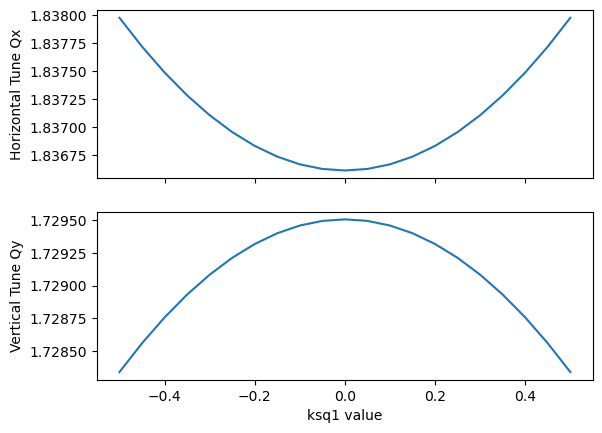

In [133]:
tws = []
ksqvals = np.linspace(-0.5, 0.5, 21)

for ksqval in ksqvals:
    line_zero_quads.vars["lnr_ksq1"] = ksqval
    tw = line_zero_quads.twiss4d()
    tws.append(tw)

fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(ksqvals, [tw.qx for tw in tws], label='Qx')
ax[1].plot(ksqvals, [tw.qy for tw in tws], label='Qy')
ax[0].set_ylabel('Horizontal Tune Qx')
ax[1].set_ylabel('Vertical Tune Qy')
ax[1].set_xlabel('ksq1 value')

Text(0.5, 0, 'ksq1 value')

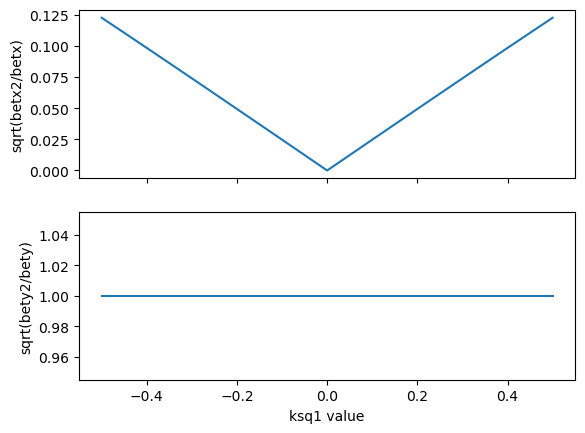

In [144]:
tws = []
ksqvals = np.linspace(-0.5, 0.5, 21)

for ksqval in ksqvals:
    line_zero_quads.vars["lnr_ksq1"] = ksqval
    tw = line_zero_quads.twiss4d()
    tws.append(tw)

fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(ksqvals, [np.sqrt(tw.betx2[0]/tw.betx[0]) for tw in tws])
ax[1].plot(ksqvals, [np.sqrt(tw.bety2[0]/tw.bety[0]) for tw in tws])
ax[0].set_ylabel('sqrt(betx2/betx)')
ax[1].set_ylabel('sqrt(bety2/bety)')
ax[1].set_xlabel('ksq1 value')

Text(0.5, 0.98, 'Spectrum without coupling')

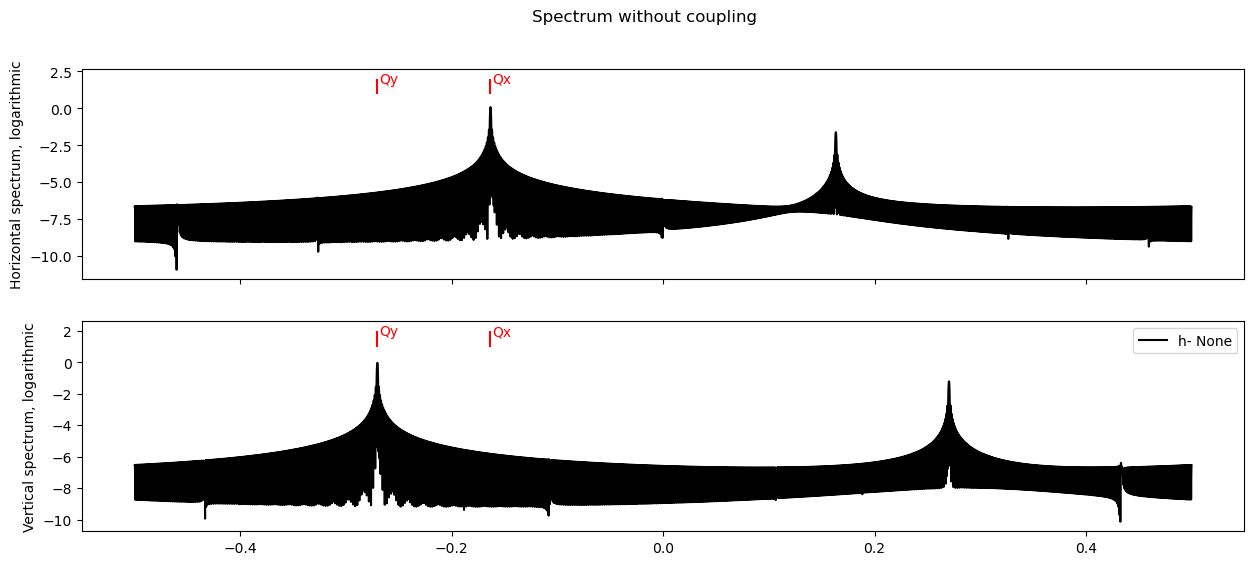

In [137]:
n_part = 5
x_init = np.linspace(0, 0.005, n_part)
y_init = np.linspace(0, 0.005, n_part)
px_init = np.zeros(n_part)
py_init = np.zeros(n_part)
particles = xt.Particles(x=x_init, y=y_init, px=px_init, py=py_init)

ksqval = 0
line_zero_quads.vars["lnr_ksq1"] = ksqval
n_turns = 1000
line_zero_quads.track(particles, num_turns=n_turns, turn_by_turn_monitor=True)

out = np.zeros((n_turns, 1, 4, n_part)) # shape (num_turns, num_elements, num_coordinates, num_particles)
for turn in range(n_turns):
    out[turn, 0] = line_zero_quads.record_last_track.x[:, turn], line_zero_quads.record_last_track.px[:, turn], \
        line_zero_quads.record_last_track.y[:, turn], line_zero_quads.record_last_track.py[:, turn]
output_nocoupling = bpmeth.Output4d(np.array([x_init, px_init, y_init, py_init]), out)

fig, ax = plt.subplots(2, figsize=(15, 6), sharex=True)
output_nocoupling.plot_spectrum_x(1, ax=ax[0])
output_nocoupling.plot_spectrum_y(1, ax=ax[1])
ax[0].vlines(x=tw0.qx-2, ymin=1, ymax=2, color="red")
ax[0].text(x=tw0.qx-2+0.002, y=1.7, s="Qx", color="red")
ax[1].vlines(x=tw0.qx-2, ymin=1, ymax=2, color="red")
ax[1].text(x=tw0.qx-2+0.002, y=1.7, s="Qx", color="red")
ax[0].vlines(x=tw0.qy-2, ymin=1, ymax=2, color="red")
ax[0].text(x=tw0.qy-2+0.002, y=1.7, s="Qy", color="red")
ax[1].vlines(x=tw0.qy-2, ymin=1, ymax=2, color="red")
ax[1].text(x=tw0.qy-2+0.002, y=1.7, s="Qy", color="red")
ax[0].set_ylabel("Horizontal spectrum, logarithmic")
ax[1].set_ylabel("Vertical spectrum, logarithmic")
fig.suptitle("Spectrum without coupling")

Text(0.5, 0.98, 'Spectrum with coupling')

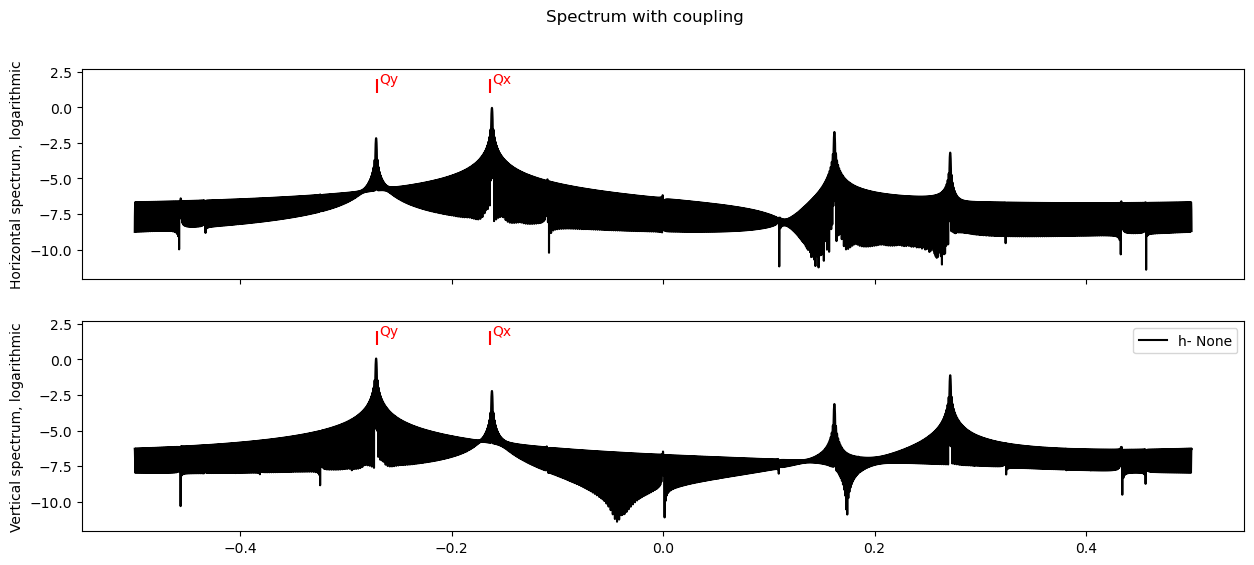

In [138]:
n_part = 5
x_init = np.linspace(0, 0.005, n_part)
y_init = np.linspace(0, 0.005, n_part)
px_init = np.zeros(n_part)
py_init = np.zeros(n_part)
particles = xt.Particles(x=x_init, y=y_init, px=px_init, py=py_init)

ksqval = 0.5
line_zero_quads.vars["lnr_ksq1"] = ksqval
n_turns = 1000
line_zero_quads.track(particles, num_turns=n_turns, turn_by_turn_monitor=True)

out = np.zeros((n_turns, 1, 4, n_part)) # shape (num_turns, num_elements, num_coordinates, num_particles)
for turn in range(n_turns):
    out[turn, 0] = line_zero_quads.record_last_track.x[:, turn], line_zero_quads.record_last_track.px[:, turn], \
        line_zero_quads.record_last_track.y[:, turn], line_zero_quads.record_last_track.py[:, turn]
output_coupling = bpmeth.Output4d(np.array([x_init, px_init, y_init, py_init]), out)

fig, ax = plt.subplots(2, figsize=(15, 6), sharex=True)
output_coupling.plot_spectrum_x(1, ax=ax[0])
output_coupling.plot_spectrum_y(1, ax=ax[1])
ax[0].vlines(x=tw0.qx-2, ymin=1, ymax=2, color="red")
ax[0].text(x=tw0.qx-2+0.002, y=1.7, s="Qx", color="red")
ax[1].vlines(x=tw0.qx-2, ymin=1, ymax=2, color="red")
ax[1].text(x=tw0.qx-2+0.002, y=1.7, s="Qx", color="red")
ax[0].vlines(x=tw0.qy-2, ymin=1, ymax=2, color="red")
ax[0].text(x=tw0.qy-2+0.002, y=1.7, s="Qy", color="red")
ax[1].vlines(x=tw0.qy-2, ymin=1, ymax=2, color="red")
ax[1].text(x=tw0.qy-2+0.002, y=1.7, s="Qy", color="red")
ax[0].set_ylabel("Horizontal spectrum, logarithmic")
ax[1].set_ylabel("Vertical spectrum, logarithmic")
fig.suptitle("Spectrum with coupling")